In [17]:
import io
import numpy as np
import pandas as pd
import functools as ft
import tensorflow as tf

import plotly.plotly as py
import plotly.graph_objs as go

import scipy.ndimage as nd
import matplotlib.pyplot as plt

from tensorflow.python.summary.event_multiplexer import EventMultiplexer
from tensorflow.python.summary.event_accumulator import STORE_EVERYTHING_SIZE_GUIDANCE

def build_runs(names, path, rounds):
    return {k: d[k] for d in [{'{}{}'.format(s, i): path.format(s, i) for i in range(1, rounds+1)} for s in names] for k in d}

def extract_loss(emp, runs):
    loss = {r: list(zip(*map(lambda s: (s.step, s.value), emp.Scalars(r, 'loss/loss')))) for r in runs.keys()}
    return pd.DataFrame({r: pd.Series(loss[r][1], name=r, index=loss[r][0]) for r in runs.keys()})

def extract_images(emp, runs):
    decode = lambda i: (i.step, nd.imread(io.BytesIO(i.encoded_image_string)))
    
    imgs = {r: list(zip(*map(decode, emp.Images(r, 'us_rendered/image')))) for r in runs}
    steps = list(imgs.values())[0][0]
    truth = list(map(decode, emp.Images(runs[0], 'us/image')))

    return [(steps[i], {'truth': truth[i][1], **{k: v[1][i] for k, v in imgs.items()}}) for i in range(len(steps))]

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.aspect'] = 'auto'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (20, 12)

def image_grid(images, offset=0, length=5):
    f, ax = plt.subplots(length, 5)

    for i in range(length):
        step = images[i+offset][0]
        imgs = images[i+offset][1]
        keys = list(imgs.keys())

        for j in range(5):
            ax[i][j].set_title('{} (step {})'.format(keys[j], step))
            ax[i][j].imshow(imgs[keys[j]])
    
    plt.show()
    
def plot_loss(loss):
    layout = go.Layout(xaxis=dict(title='step'), yaxis=dict(title='norm'))
    data = [go.Scatter(name=c, x=loss.index, y=loss[c]) for c in loss.columns]

    py.iplot(go.Figure(data=data, layout=layout))

In [2]:
th10_runs = build_runs(['test', 'train'], '/tmp/mrtous/{}/th10/{}', 4)
th30_runs = build_runs(['test', 'train'], '/tmp/mrtous/{}/th30/{}', 4)

th10_emp = EventMultiplexer(th10_runs, size_guidance=STORE_EVERYTHING_SIZE_GUIDANCE)
th30_emp = EventMultiplexer(th30_runs, size_guidance=STORE_EVERYTHING_SIZE_GUIDANCE)

th10_emp.Reload()
th30_emp.Reload()

INFO:tensorflow:Event Multiplexer initializing.
INFO:tensorflow:Event Multplexer doing initialization load for {'train2': '/tmp/mrtous/train/th10/2', 'test3': '/tmp/mrtous/test/th10/3', 'train3': '/tmp/mrtous/train/th10/3', 'test4': '/tmp/mrtous/test/th10/4', 'test2': '/tmp/mrtous/test/th10/2', 'test1': '/tmp/mrtous/test/th10/1', 'train1': '/tmp/mrtous/train/th10/1', 'train4': '/tmp/mrtous/train/th10/4'}
INFO:tensorflow:Constructing EventAccumulator for /tmp/mrtous/train/th10/2
INFO:tensorflow:Constructing EventAccumulator for /tmp/mrtous/test/th10/3
INFO:tensorflow:Constructing EventAccumulator for /tmp/mrtous/train/th10/3
INFO:tensorflow:Constructing EventAccumulator for /tmp/mrtous/test/th10/4
INFO:tensorflow:Constructing EventAccumulator for /tmp/mrtous/test/th10/2
INFO:tensorflow:Constructing EventAccumulator for /tmp/mrtous/test/th10/1
INFO:tensorflow:Constructing EventAccumulator for /tmp/mrtous/train/th10/1
INFO:tensorflow:Constructing EventAccumulator for /tmp/mrtous/train/th1

In [3]:
th10_loss = extract_loss(th10_emp, th10_runs)
th30_loss = extract_loss(th30_emp, th30_runs)

test_cols = ['test1', 'test2', 'test3', 'test4']
train_cols = ['train1', 'train2', 'train3', 'train4']

th10_test_loss = th10_loss[test_cols].dropna()
th30_test_loss = th10_loss[test_cols].dropna()

th10_train_loss = th10_loss[train_cols]
th30_train_loss = th30_loss[train_cols]

In [8]:
py.iplot(loss_figure(th10_test_loss[:1000]))

In [10]:
py.iplot(loss_figure(th30_test_loss[:1000]))

In [12]:
py.iplot(loss_figure(th10_train_loss[:600]))

In [13]:
py.iplot(loss_figure(th30_train_loss[:600]))

In [14]:
th10_test_images = extract_images(th10_emp, test_cols)
th30_test_images = extract_images(th30_emp, test_cols)

th10_train_images = extract_images(th10_emp, train_cols)
th30_train_images = extract_images(th30_emp, train_cols)

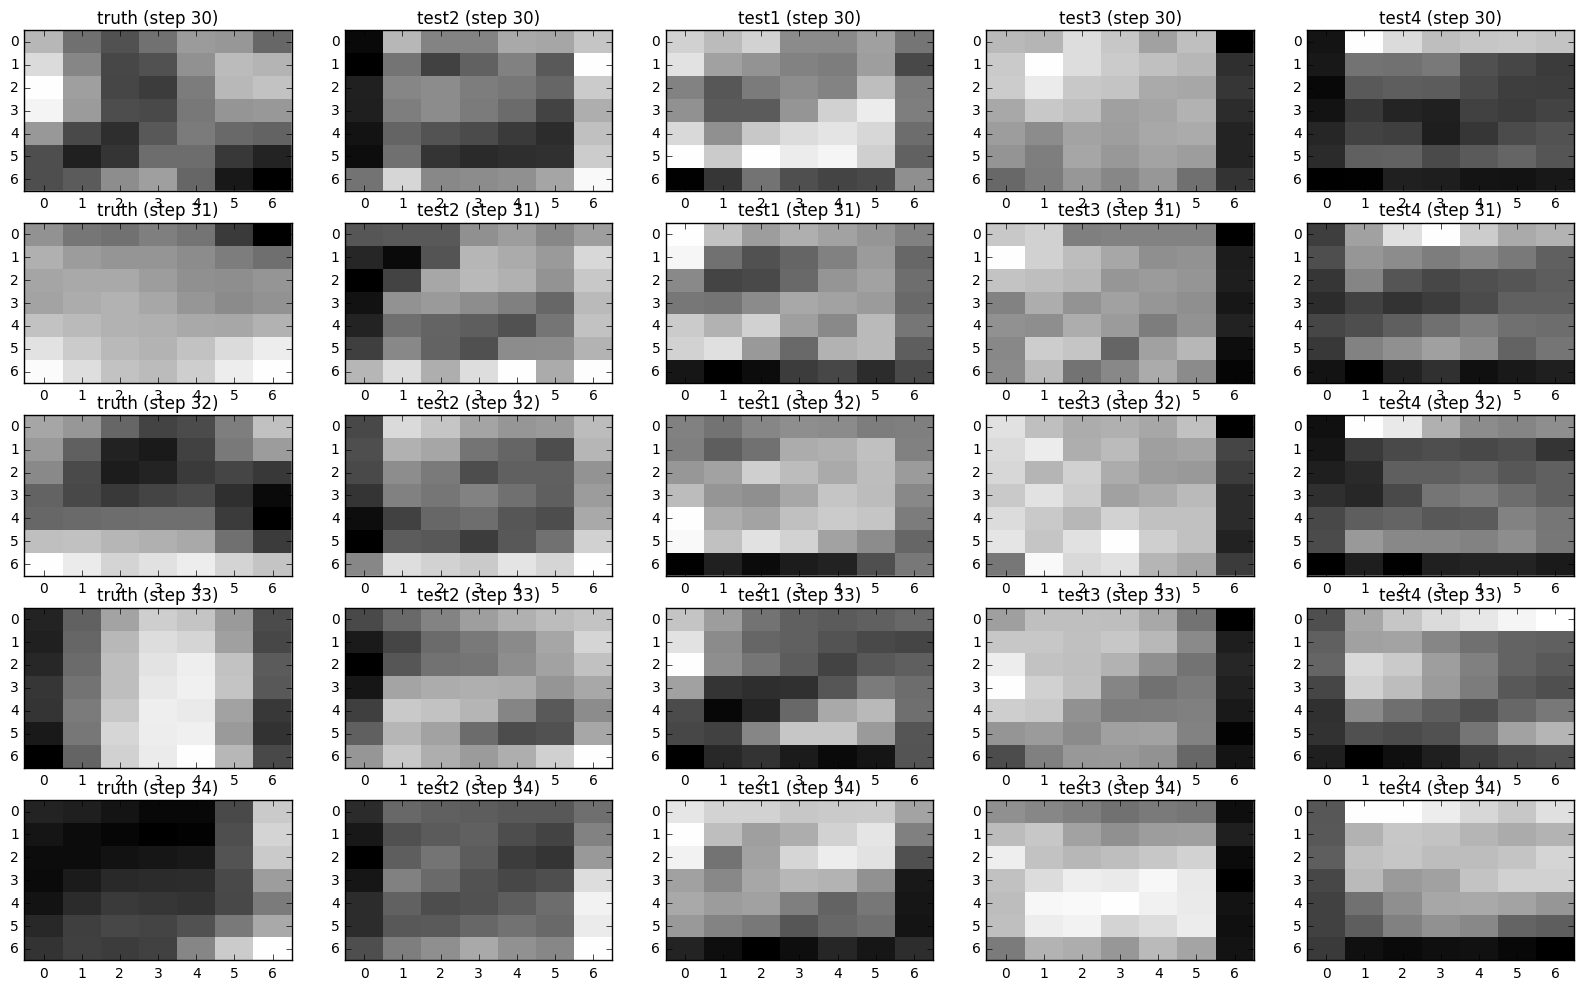

In [19]:
image_grid(th10_test_images, 30)

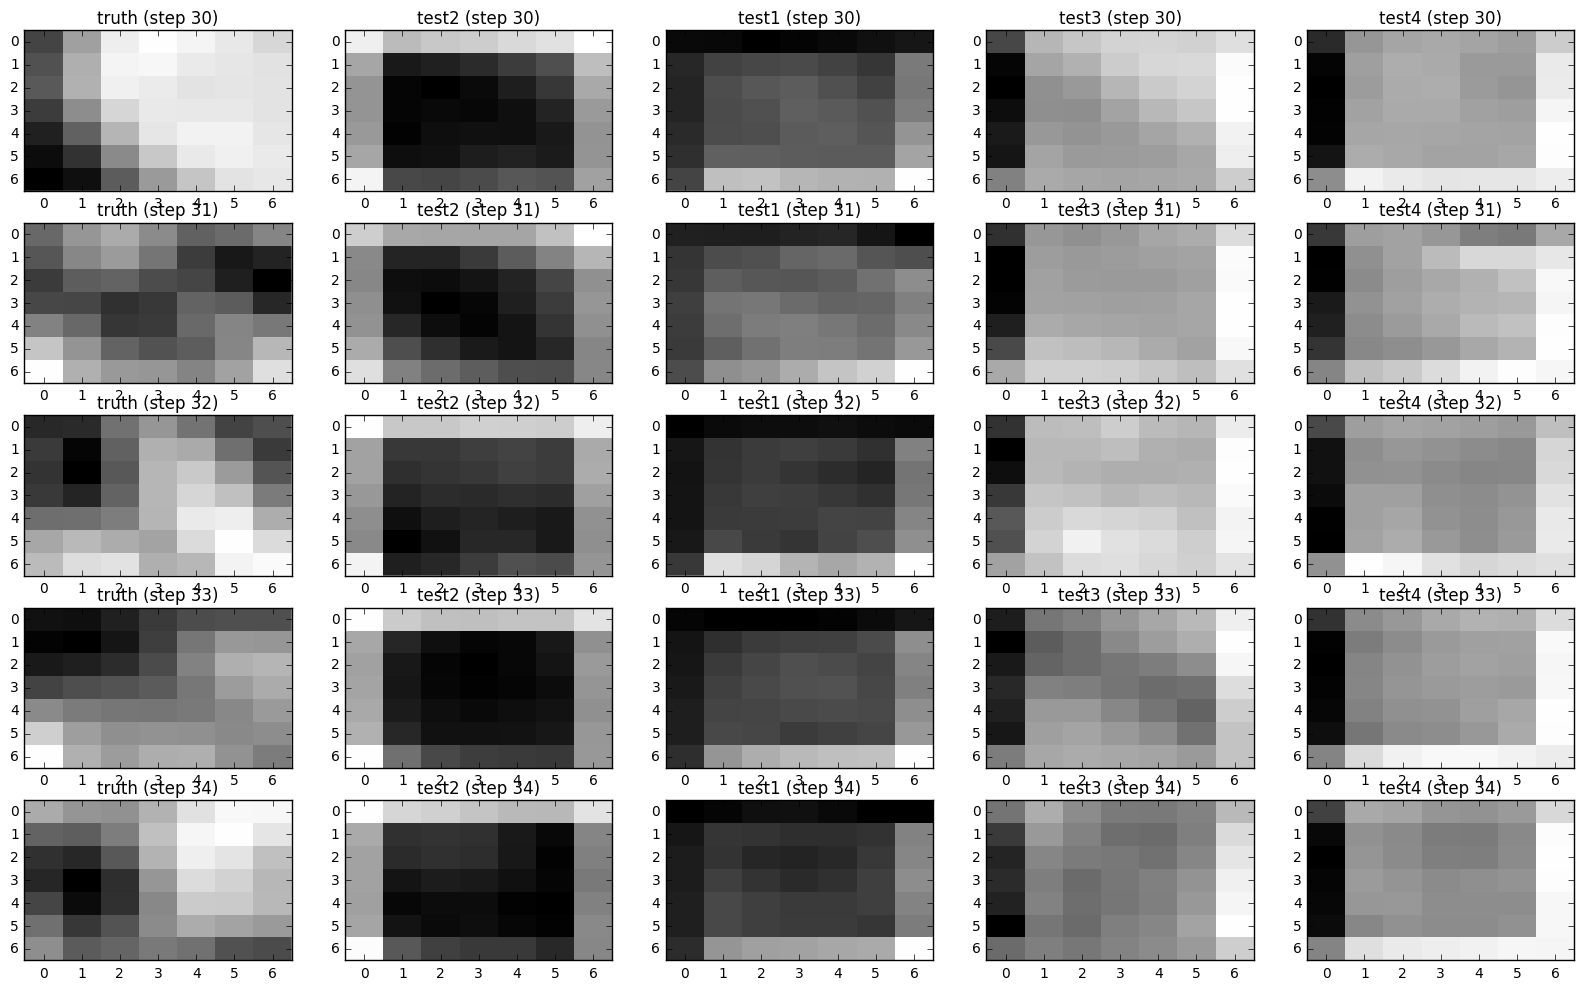

In [27]:
image_grid(th30_test_images, 30)